### Visualizing the distribution of the observations

### Load the required libraries

In [2]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math
%pylab inline

import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from spark_PCA import computeCov
from computeStats import computeOverAllDist, STAT_Descriptions

### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='SBBBBBSB'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print 'keys from STAT=',STAT.keys()

#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index

df=sqlContext.read.parquet(filename)
print df.count()
df.show(5)

Populating the interactive namespace from numpy and matplotlib
keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']
12673
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|    500.2| 48.7603|-101.5089|       TMAX|USC00326025|    40|[90 D5 00 7E 00 7...|1894.0|SBBBBBSB|
|    500.2| 48.7603|-101.5089|       TMAX|USC00326025|    43|[A0 D6 A0 D6 00 7...|1895.0|SBBBBBSB|
|    500.2| 48.7603|-101.5089|       TMAX|USC00326025|    22|[A0 D3 00 C6 00 0...|1898.0|SBBBBBSB|
|    500.2| 48.7603|-101.5089|       TMAX|USC00326025|    47|[00 7E E0 D5 A0 D...|1900.0|SBBBBBSB|
|    500.2| 48.7603|-101.5089|       TMAX|USC00326025|    47|[00 7E 00 7E 00 7...|1901.0|SBBBBBSB|
+---------+--------+---------+-----------+-----------+------+-------------

### Select data for a particular station and measurement type

In [15]:
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT * FROM weather\n\tWHERE measurement='%s' and station='%s'"%('PRCP','USC00326025')
print Query
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
df1.show(2)
rows=df1.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
T=np.vstack(rows)
T=T/10.  # scaling to make the temperature be in centingrates
shape(T)

SELECT * FROM weather
	WHERE measurement='PRCP' and station='USC00326025'
94 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|    500.2| 48.7603|-101.5089|       PRCP|USC00326025|    31|[80 50 00 00 00 0...|1894.0|SBBBBBSB|
|    500.2| 48.7603|-101.5089|       PRCP|USC00326025|     0|[00 00 C0 54 00 0...|1896.0|SBBBBBSB|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 2 rows



(94, 365)

### Script for plotting yearly plots

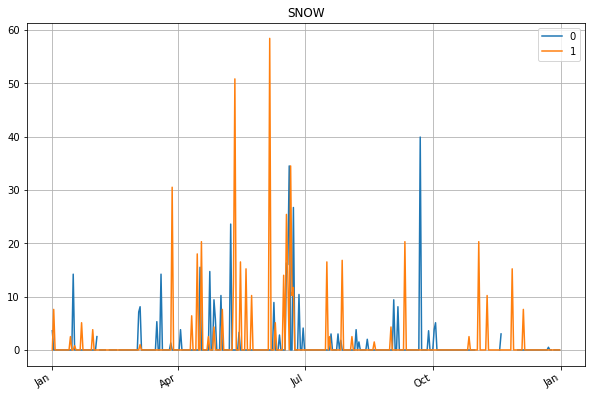

In [16]:
from YearPlotter import YearPlotter
fig, ax = plt.subplots(figsize=(10,7));
YP=YearPlotter()
YP.plot(T[:2,:].transpose(),fig,ax,title='SNOW')
#title('A sample of graphs');

### Distribution of missing observations
The distribution of missing observations is not uniform throughout the year. We visualize it below.

In [17]:
def plot_pair(pair,func):
    j=0
    fig,X=subplots(1,2,figsize=(16,6))
    axes=X.reshape(2)
    for m in pair:
        axis = axes[j]
        j+=1
        func(m,fig,axis)
        
def plot_valid(m,fig,axis):
    valid_m=STAT[m]['NE']
    YP.plot(valid_m,fig,axis,title='valid-counts '+m)
    

/Users/MichaelZhao/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


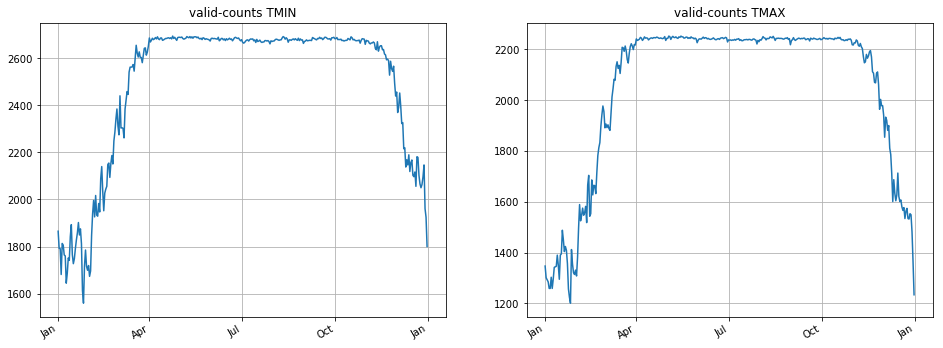

In [18]:
plot_pair(['TMIN','TMAX'],plot_valid)

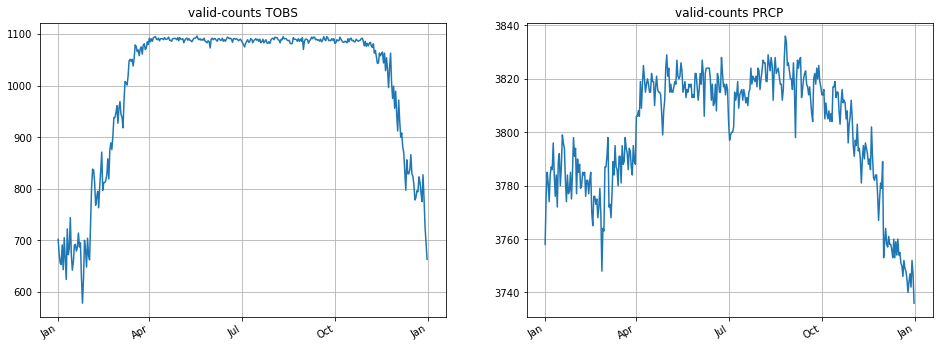

In [19]:
plot_pair(['TOBS','PRCP'],plot_valid)

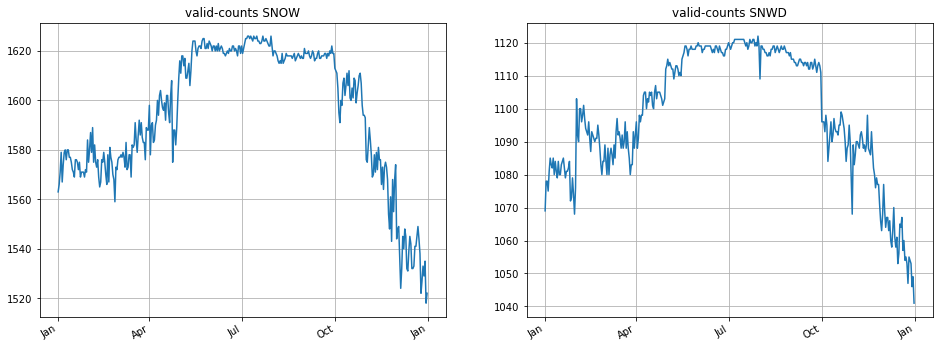

In [20]:
plot_pair(['SNOW', 'SNWD'],plot_valid)

### Plots of mean and std of observations

In [21]:
def plot_mean_std(m,fig,axis):
    mean=STAT[m]['Mean']/10
    std=np.sqrt(STAT[m]['Var'])/10
    graphs=np.vstack([mean-std,mean,mean+std]).transpose()
    YP.plot(graphs,fig,axis,title='Mean+-std   '+m)

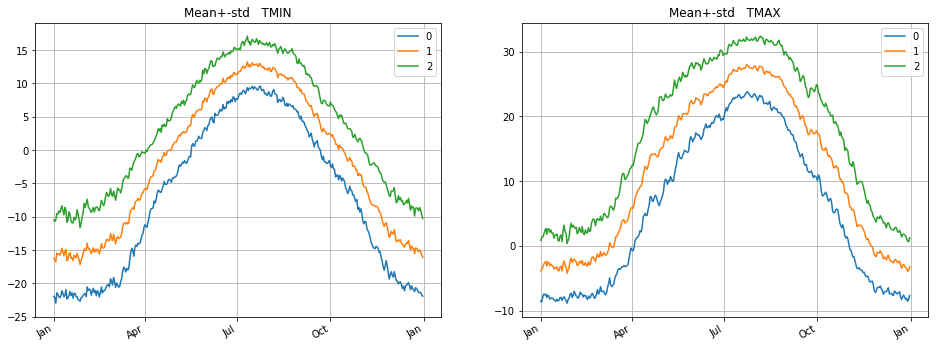

In [22]:
plot_pair(['TMIN','TMAX'],plot_mean_std)

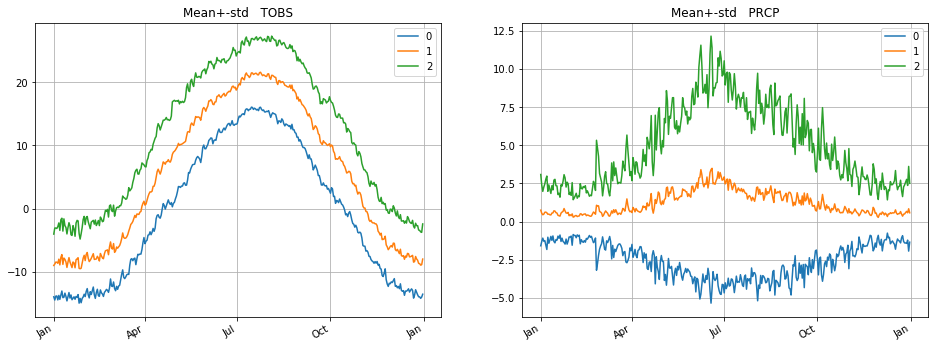

In [23]:
plot_pair(['TOBS','PRCP'],plot_mean_std)

In [9]:
np.sum(STAT['PRCP']['Mean'])/1000

4.4375262278254857

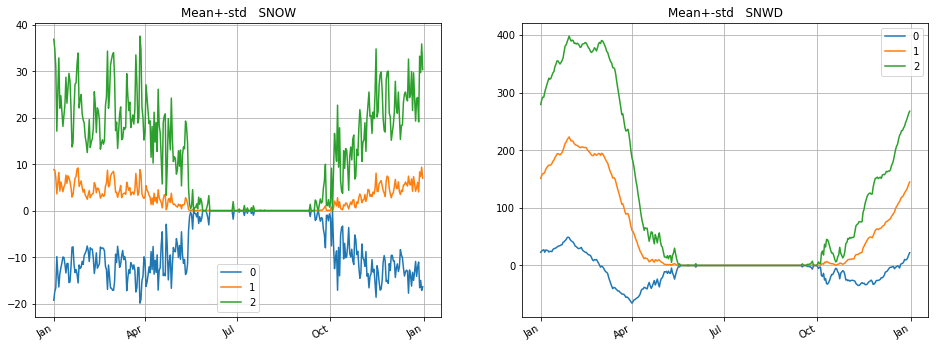

In [11]:
plot_pair(['SNOW', 'SNWD'],plot_mean_std)

### plotting top 3 eigenvectors

In [12]:
def plot_eigen(m,fig,axis):
    EV=STAT[m]['eigvec']
    YP.plot(EV[:,:3],fig,axis,title='Top Eigenvectors '+m)

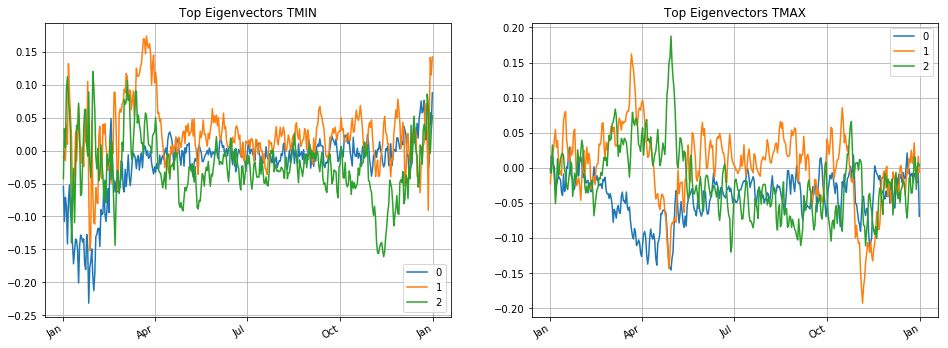

In [13]:
plot_pair(['TMIN','TMAX'],plot_eigen)

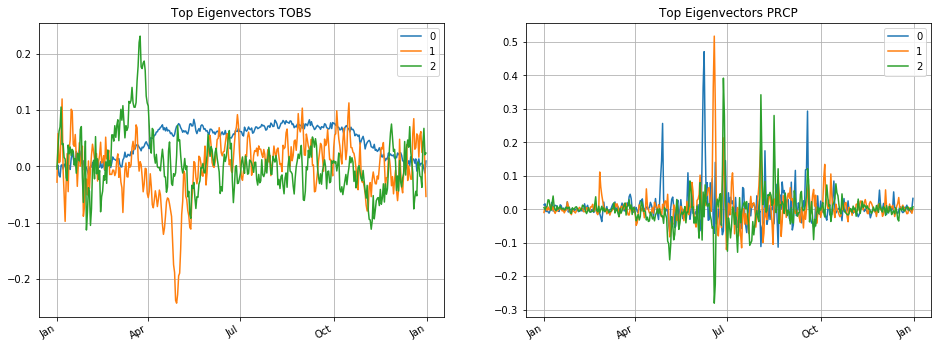

In [14]:
plot_pair(['TOBS','PRCP'],plot_eigen)

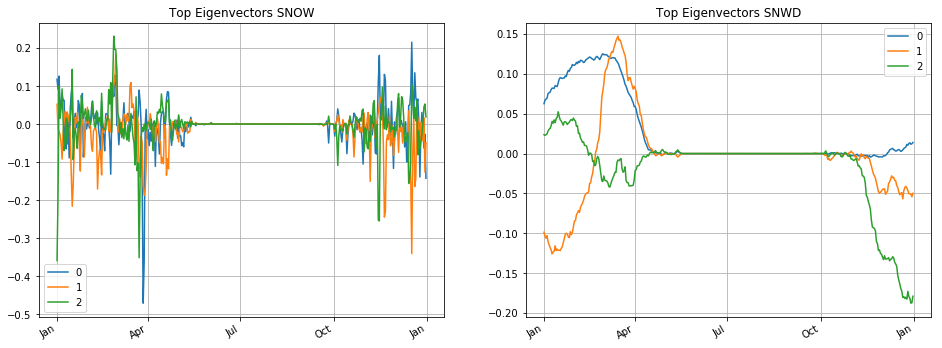

In [15]:
plot_pair(['SNOW', 'SNWD'],plot_eigen)

### Script for plotting percentage of variance explained

In [16]:
def pltVarExplained(j):
    subplot(1,3,j)
    EV=STAT[m]['eigval']
    k=5
    plot(([0,]+list(cumsum(EV[:k])))/sum(EV))
    title('Percentage of Variance Explained for '+ m)
    ylabel('Percentage of Variance')
    xlabel('# Eigenvector')
    grid()
    

In [21]:
STAT['TMIN']['eigval']

array([ -3.41784835e+04,   4.09377287e+04,   3.76750534e+04,
         3.38151423e+04,   3.17791357e+04,   2.90934500e+04,
         2.79340237e+04,   2.68580957e+04,   2.55786874e+04,
        -1.77345803e+04,  -1.48172476e+04,   2.42423409e+04,
         2.32696767e+04,   2.22035031e+04,   2.22254663e+04,
        -1.10727827e+04,   2.11197600e+04,  -1.00400212e+04,
         1.98595645e+04,   1.95481138e+04,   1.92674333e+04,
        -8.47470280e+03,   1.81277544e+04,   1.74974396e+04,
         1.71138819e+04,  -7.66547991e+03,   1.59491169e+04,
         1.56169162e+04,   1.51943653e+04,   1.46278826e+04,
         1.40716756e+04,   1.36561651e+04,   1.34119566e+04,
         1.28916769e+04,   1.25864328e+04,   1.20742875e+04,
         1.16866000e+04,   1.13934821e+04,   1.11269700e+04,
         1.08724891e+04,   1.06925261e+04,   1.02347420e+04,
         9.41620875e+03,   9.61030716e+03,   9.86635832e+03,
         9.91478292e+03,  -5.59849646e+03,  -5.12601478e+03,
        -4.44184308e+03,

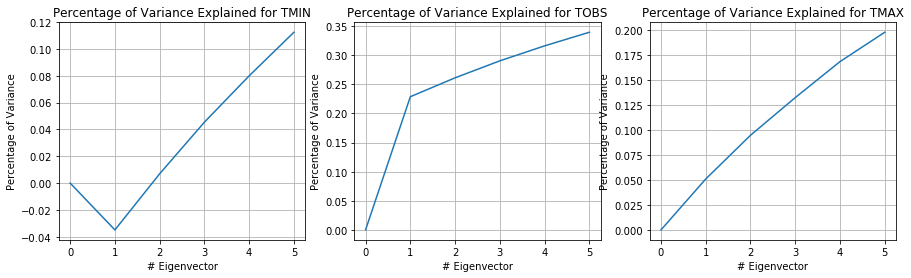

In [21]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['TMIN', 'TOBS', 'TMAX']: #,
    pltVarExplained(j)
    j+=1

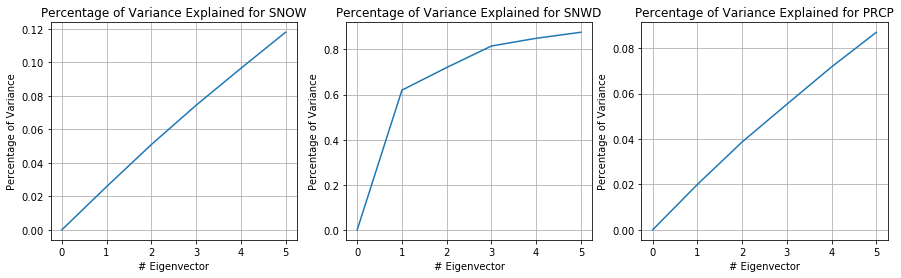

In [22]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['SNOW', 'SNWD', 'PRCP']:
    pltVarExplained(j)
    j+=1 

In [19]:
#sc.stop()